# Assigning Country Covariate Values To Measurements

## The Covariates

In [120]:
from db_tools.ezfuncs import query
df = query("select * from shared.covariate", conn_def="dismod-at-dev")
print(df.columns)
print()
print(df.shape)

Index(['covariate_id', 'covariate_name_short', 'covariate_name',
       'covariate_lancet_label', 'requested_by', 'covariate_description',
       'group_display', 'by_age', 'by_sex', 'dichotomous', 'inactive',
       'covariate_type_id', 'start_date', 'end_date', 'date_inserted',
       'last_updated', 'last_updated_by', 'last_updated_action'],
      dtype='object')

(1191, 18)


In [119]:
df_active = df[df["inactive"] == 0]
print(f"Number of active covariates: {len(df_active)}")
print()
print("Types of Active Covariates")
print()
not_by_age_not_by_sex = len(df_active[(df_active["by_age"] == 0) & (df_active["by_sex"] == 0)])
print(f"not_by_age_not_by_sex: {not_by_age_not_by_sex}")
not_by_age_but_by_sex = len(df_active[(df_active["by_age"] == 0) & (df_active["by_sex"] == 1)])
print(f"not_by_age but by_sex: {not_by_age_but_by_sex}")
not_by_sex_but_by_age = len(df_active[(df_active["by_age"] == 1) & (df_active["by_sex"] == 0)])
print(f"not_by_sex but by_age: {not_by_sex_but_by_age}")
by_age_and_by_sex = len(df_active[(df_active["by_age"] == 1) & (df_active["by_sex"] == 1)])
print(f"by_age and by_sex: {by_age_and_by_sex}")
print()
df_dichot = df_active[df_active["dichotomous"]==1]
print(f"Number of active dichotomous covariates: {len(df_dichot)}")
print()
covs_dichot = ('\n').join(df_dichot['covariate_name_short'].tolist())
print(f"Active dichotomous covariates \n\n {covs_dichot}")

Number of active covariates: 662

Types of Active Covariates

not_by_age_not_by_sex: 277
not_by_age but by_sex: 203
not_by_sex but by_age: 8
by_age and by_sex: 174

Number of active dichotomous covariates: 7

Active dichotomous covariates 

 H5N1_epidemic_yrs_bin
cv_je_bin
fortification_standard
fortification_standard_FA
fortification_standard_iron
censuses
nash_definition


## The Algorithms

### Algorithm 1: kdtree based on 3 dimensions - age, time, and sex

### Algorithm 2: interpolation grid by sex, with age and time dimensions

Linear interpolation is used to determine a covariate value over an age and time grid 
specified by the mid-points of the age and time intervals in the covariate data.  


### Algorithm 3:  population-weighted interpolation grid by sex, with age and time dimensions

## Load the Data

In [16]:
# imports
from cascade.input_data.db.bundle import _get_bundle_data
from cascade.testing_utilities import make_execution_context
from cascade.input_data.configuration.builder import (
    assign_interpolated_covariate_values, get_all_age_spans, convert_gbd_ids_to_dismod_values)
from cascade.input_data.db.ccov import country_covariates

In [121]:
# create execution context
execution_context = make_execution_context()
execution_context.parameters.gbd_round_id = 5

In [130]:
# measurements - diabetes
bundle_id = 173
tier = 3
print(f"measurement bundle {bundle_id}, tier {tier}")
print()
measurements = _get_bundle_data(execution_context, bundle_id)

measurements["x_sex"] = measurements["sex_id"].replace([1,2,3],[0.5,-0.5,0])

measurements["age_lower"] = measurements["age_start"]
measurements["age_upper"] = measurements["age_end"]

measurements["time_lower"] = measurements["year_start"]
measurements["time_upper"] = measurements["year_end"]

measurements["avg_age"] = measurements[["age_lower", "age_upper"]].mean(axis=1)
measurements["avg_time"] = measurements[["time_lower", "time_upper"]].mean(axis=1)

print(f"measurements columns \n{measurements.columns}")
print()
print(measurements.shape)
print()

# measure_id's: 5=prevalence, 6=incidence, 11=relrisk, 13=mtwith
print("measure ids")
print(measurements["measure_id"].unique())
print()

tm = measurements["avg_time"].unique()
tml = tm.tolist()
tml.sort()
print("measurements avg_time")
print(tml)      
print()

am = measurements["avg_age"].unique()
aml = am.tolist()
aml.sort()
print("measurements avg_age")
print(aml)
print()


measurement bundle 173, tier 3

measurements columns 
Index(['bundle_id', 'seq', 'request_id', 'input_type_id', 'nid',
       'underlying_nid', 'location_id', 'sex_id', 'year_start', 'year_end',
       'age_start', 'age_end', 'measure_id', 'source_type_id',
       'sampling_type_id', 'representative_id', 'urbanicity_type_id',
       'recall_type_id', 'recall_type_value', 'unit_type_id',
       'unit_value_as_published', 'uncertainty_type_id',
       'uncertainty_type_value', 'mean', 'lower', 'upper', 'standard_error',
       'effective_sample_size', 'sample_size', 'cases', 'design_effect',
       'outlier_type_id', 'x_sex', 'age_lower', 'age_upper', 'time_lower',
       'time_upper', 'avg_age', 'avg_time'],
      dtype='object')

(275800, 39)

measure ids
[ 5 11 13  6]

measurements avg_time
[1965.0, 1968.5, 1970.0, 1971.5, 1975.0, 1978.0, 1979.0, 1980.0, 1981.0, 1981.5, 1982.0, 1982.5, 1983.0, 1983.5, 1984.0, 1984.5, 1985.0, 1985.5, 1986.0, 1986.5, 1987.0, 1987.5, 1988.0, 1988.5, 1989

In [149]:
# covariates - cum cigs 20 yr

covariate_id = 26
location_id = 102
demographics = dict(
            age_group_ids="all", year_ids="all", sex_ids="all", location_ids=[location_id]
        )
covariates = country_covariates(covariate_id, demographics, execution_context.parameters.gbd_round_id)

covariate_name = covariates.iloc[0]["covariate_name_short"]
print(f"covariate {covariate_name}, covariate_id = {covariate_id}")
print()

print(f"covariates columns {covariates.columns}")
print()      
print(f"covariates shape: {covariates.shape}")
print()
print(f"covariates age_group_ids: {covariates['age_group_id'].unique()}")
print()

age_groups = get_all_age_spans(execution_context)
print("age groups")
print(age_groups.columns)
print(age_groups.shape)
print()

# add age start and end cols      
ccov_ranges_df = convert_gbd_ids_to_dismod_values(covariates, age_groups)

print(f"ccov_ranges_df columns \n {ccov_ranges_df.columns}")
print()
print(f"ccov_ranges_df shape: {ccov_ranges_df.shape}")
print()

print("unique x_sex values")
print(ccov_ranges_df["x_sex"].unique())
print()

ccov_ranges_df["avg_time"] = ccov_ranges_df[["time_lower", "time_upper"]].mean(axis=1)
print("Covariates avg_time")
print(ccov_ranges_df["avg_time"].unique())
print()
print("Covariates time_lower")
print(ccov_ranges_df["time_lower"].unique())
print()
print("Covariates time_upper")
print(ccov_ranges_df["time_upper"].unique())
print()

ccov_ranges_df["avg_age"] = ccov_ranges_df[["age_lower", "age_upper"]].mean(axis=1)      
      
ac = ccov_ranges_df["avg_age"].unique()
acl = ac.tolist()
acl.sort()
print(f"Covariates avg_age \n {acl}")
print()
      
ccov_ranges_df_2003 = ccov_ranges_df[ccov_ranges_df["avg_time"] == 2003.5]
print(f"ccov_ranges_df_2003.5 shape: {ccov_ranges_df_2003.shape}")
ccov_ranges_df_2002 = ccov_ranges_df[ccov_ranges_df["avg_time"] == 2002.5]
print(f"ccov_ranges_df_2002.5 shape: {ccov_ranges_df_2002.shape}")

covariate cum_cigs_20_yr, covariate_id = 26

covariates columns Index(['covariate_id', 'covariate_name_short', 'location_id', 'age_group_id',
       'year_id', 'sex_id', 'mean_value'],
      dtype='object')

covariates shape: (1748, 7)

covariates age_group_ids: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  30  31  32 235]

age groups
Index(['age_group_id', 'age_group_years_start', 'age_group_years_end'], dtype='object')
(391, 3)

ccov_ranges_df columns 
 Index(['index', 'covariate_id', 'covariate_name_short', 'location_id',
       'sex_id', 'mean_value', 'age_lower', 'age_upper', 'x_sex', 'time_lower',
       'time_upper'],
      dtype='object')

ccov_ranges_df shape: (1748, 11)

unique x_sex values
[ 0.5 -0.5]

Covariates avg_time
[1980.5 1981.5 1982.5 1983.5 1984.5 1985.5 1986.5 1987.5 1988.5 1989.5
 1990.5 1991.5 1992.5 1993.5 1994.5 1995.5 1996.5 1997.5 1998.5 1999.5
 2000.5 2001.5 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5
 2010.5 201

In [146]:
# Compute Assigned Covariate Value

covariate_column = assign_interpolated_covariate_values(measurements, ccov_ranges_df)
measurements["covariate_col"] = covariate_column

print(f"covariate_column shape \n {covariate_column.shape}")
print()

covariate_column shape 
 (275800,)



In [163]:
# subset on sex "both" and prevalence

meas_5_both = measurements[(measurements["x_sex"] == 0) & (measurements["measure_id"] == 5)]

print("measurements subset: sex 'both' and prevalence")
print(meas_5_both.shape)
print()

print("avg_time")
tm5 = meas_5_both["avg_time"].unique()
tm5l = tm5.tolist()
tm5l.sort()
print(tm5l)
print()

print("avg_age")
am5 = meas_5_both["avg_age"].unique()
am5l = am5.tolist()
am5l.sort()
print(am5l)
print()

measurements subset: sex 'both' and prevalence
(3017, 40)

avg_time
[1980.0, 1983.0, 1985.0, 1987.0, 1989.0, 1991.5, 1992.0, 1992.5, 1993.5, 1995.0, 1995.5, 1996.0, 1996.5, 1997.0, 1998.0, 1998.5, 1999.0, 1999.5, 2000.0, 2000.5, 2001.0, 2001.5, 2002.0, 2002.5, 2003.0, 2003.5, 2004.0, 2004.5, 2005.0, 2005.5, 2006.0, 2006.5, 2007.0, 2007.5, 2008.0, 2008.5, 2009.0, 2009.5, 2010.0, 2010.5, 2011.0, 2011.5, 2012.0, 2012.5, 2013.0, 2013.5, 2014.0, 2015.0]

avg_age
[3.0, 5.5, 7.0, 9.5, 11.0, 12.5, 14.5, 15.0, 17.0, 17.5, 18.5, 19.5, 21.0, 21.5, 22.0, 23.5, 24.5, 25.5, 26.0, 26.5, 27.0, 28.0, 28.5, 29.5, 30.0, 31.0, 32.0, 32.5, 34.5, 35.0, 35.5, 37.0, 39.5, 40.5, 41.5, 42.0, 43.5, 44.5, 45.5, 46.0, 46.5, 47.0, 47.5, 48.5, 49.0, 49.5, 50.0, 50.5, 51.5, 52.0, 52.5, 53.0, 54.5, 55.0, 55.5, 56.0, 57.0, 57.5, 58.5, 59.0, 59.5, 60.0, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 64.5, 65.5, 67.0, 69.5, 70.0, 70.5, 72.0, 74.5, 75.0, 76.5, 77.0, 79.5, 80.0, 82.0, 84.0, 84.5, 85.5, 87.0, 89.5, 95.0, 98.5]



## Examples:  matching covariate values with measurement data

Case 1: the covariate is not a by_age covariate (in which case there is only one "age" in the data, age_group = 22 or age_group = 27) and exists for more than one year.  A 1D linear interpolation is used over time.

In [150]:
# this is not the case for covariate 26, it is by_age

Case 2: the covariate exists for only one year and for more than one age.  A 1D linear interpolation is used over age.

In [151]:
# subset covariate 26 data for the example, by selecting out only year 2003
cov_col_2003 = assign_interpolated_covariate_values(measurements, ccov_ranges_df_2003)

print(f"covariate_column_2003 shape \n {cov_col_2003.shape}")
print()

covariate_column_2003 shape 
 (275800,)



Case 3: the covariate has multiple age_group values and multiple year values.  A 2D linear 
    interpolation is used.

In [ ]:
# use covariate_column computed above


Case 4: the covariate is not by_sex.  A single interpolator is used for female, male, and 
    both_sexes measurement values.

In [ ]:
# covariate 26 is by_sex

Case 5: the covariate is by_sex. Three separate interpolators are created - one for females, one for males, and the average of the male and female values for both_sexes (the covariate data will exist for males and females, but not for both)

In [152]:
# this is true for covariate 26

Case 6: measurement value has an age interval which does not overlap with the age intervals available in the covariate data, the covariate value is assigned missing.  For example, the covariate might apply only to adults, and not to children.  

In [160]:
# Q: is this true for covariate 26? 
# A: data exists where you might not expect it, but the value is zero

ccov_age_3 = ccov_ranges_df[ccov_ranges_df['avg_age'] == 3]
print(f"cumumlative cigs for 20 yrs, for avg age 3 \n {ccov_age_3.shape}")
print()
print(f"min cov value {ccov_age_3['mean_value'].min()}")
print(f"max cov value {ccov_age_3['mean_value'].max()}")
      

cumumlative cigs for 20 yrs, for avg age 3 
 (76, 13)

min cov 0.0
max cov 0.0


Case 7: the measurement value has a year which falls outside the covariate interpolation grid, an extrapolated value will be assigned. 

In [161]:
# the measurement data has a number of years before 1980 where the covariate data begins

plot experiments

(874, 13)
(874, 13)
meas_ss_405: (7, 40)
(7, 40)
1389      2003
40789     2003
80189     2003
119589    2003
158989    2003
198389    2003
237789    2003
Name: time_lower, dtype: int64
1389      2003
40789     2003
80189     2003
119589    2003
158989    2003
198389    2003
237789    2003
Name: time_upper, dtype: int64
cov_m_2003: (23, 13)
cov_m_2002: (23, 13)
cov_f_2003: (23, 13)
cov_f_2002: (23, 13)
meas_2003 shape: (91, 40)
meas_2003 40.5: 
1389      366.877726
40789     366.877726
80189     366.877726
119589    366.877726
158989    366.877726
198389    366.877726
237789    366.877726
Name: covariate_col, dtype: float64


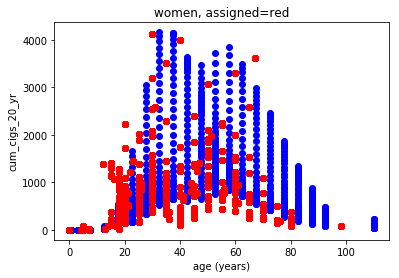

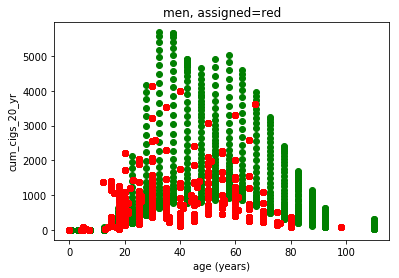

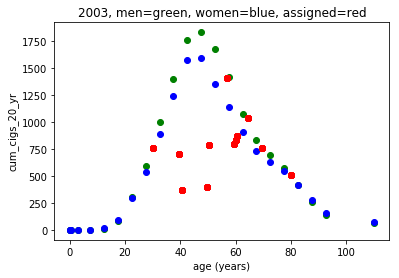

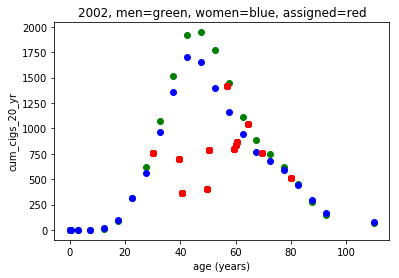

In [165]:
# Plot Covariate Value by Age by Sex

#fig, ax = plt.subplots()

cov_f = ccov_ranges_df[ccov_ranges_df["x_sex"] == -0.5]
cov_m = ccov_ranges_df[ccov_ranges_df["x_sex"] == 0.5]

#meas = measurements.iloc[0]["age_lower"]
meas = meas_5_both["age_lower"]
meas_5_both["avg_age"] = meas_5_both[["age_lower", "age_upper"]].mean(axis=1)
cc = meas_5_both["covariate_col"]

print(cov_f.shape)
print(cov_m.shape)

f_age = cov_f[["age_lower", "age_upper"]].mean(axis=1)
f_covariate = cov_f["mean_value"]

m_age = cov_m[["age_lower", "age_upper"]].mean(axis=1)
m_covariate = cov_m["mean_value"]

plt.figure(1)

plt.plot(f_age, f_covariate, 'bo')
plt.plot(meas, cc, "ro")


plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"women, assigned=red")

#plt.set(xlabel='age (years)', ylabel=covariate_name,
#       title=f"{covariate_name} by age for women")

plt.figure(2)

plt.plot(m_age, m_covariate, 'go')

# print(f"meas: {meas}")
# print(f"cc: {cc}")
plt.plot(meas, cc, "ro")

plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"men, assigned=red")

#plt.set(xlabel='age (years)', ylabel=covariate_name,
#       title=f"{covariate_name} by age for men")

meas_ss = meas_5_both[(meas_5_both["covariate_col"] < 500) & (meas_5_both["avg_age"] == 40.5)]
meas_ss_405 = meas_5_both[meas_5_both["avg_age"] == 40.5]

print(f"meas_ss_405: {meas_ss_405.shape}")
print(meas_ss.shape)
print(meas_ss["time_lower"])
print(meas_ss["time_upper"])

plt.figure(3)


cov_m_2003 = cov_m[(cov_m["time_lower"] == 2003) & (cov_m["time_upper"] == 2004)]
print(f"cov_m_2003: {cov_m_2003.shape}")

cov_m_2002 = cov_m[(cov_m["time_lower"] == 2002) & (cov_m["time_upper"] == 2003)]
print(f"cov_m_2002: {cov_m_2002.shape}")


cov_f_2003 = cov_f[(cov_f["time_lower"] == 2003) & (cov_f["time_upper"] == 2004)]
print(f"cov_f_2003: {cov_f_2003.shape}")

cov_f_2002 = cov_f[(cov_f["time_lower"] == 2002) & (cov_f["time_upper"] == 2003)]
print(f"cov_f_2002: {cov_f_2002.shape}")


m_age_2003 = cov_m_2003[["age_lower", "age_upper"]].mean(axis=1)
m_covariate_2003 = cov_m_2003["mean_value"]

m_age_2002 = cov_m_2002[["age_lower", "age_upper"]].mean(axis=1)
m_covariate_2002 = cov_m_2002["mean_value"]


f_age_2003 = cov_f_2003[["age_lower", "age_upper"]].mean(axis=1)
f_covariate_2003 = cov_f_2003["mean_value"]

f_age_2002 = cov_f_2002[["age_lower", "age_upper"]].mean(axis=1)
f_covariate_2002 = cov_f_2002["mean_value"]


plt.plot(m_age_2003, m_covariate_2003, "go")
plt.plot(f_age_2003, f_covariate_2003, "bo")

meas_2003 = meas_5_both[(meas_5_both["time_lower"]==2003) & (meas_5_both["time_upper"]==2003)]
print(f"meas_2003 shape: {meas_2003.shape}")
meas_2003_405 = meas_2003[meas_2003["avg_age"]==40.5]
print(f"meas_2003 40.5: \n{meas_2003_405['covariate_col']}")

plt.plot(meas_2003["avg_age"], meas_2003["covariate_col"], "ro")

plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"2003, men=green, women=blue, assigned=red")
      
      
plt.figure(4)

plt.plot(m_age_2002, m_covariate_2002, "go")
plt.plot(f_age_2002, f_covariate_2002, "bo")

plt.plot(meas_2003["avg_age"], meas_2003["covariate_col"], "ro")

plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"2002, men=green, women=blue, assigned=red")
      

plt.show()

